# How do I create my own dataset?

So Caffe2 uses a binary DB format to store the data that we would like to train models on. A Caffe2 DB is a glorified name of a key-value storage where the keys are usually randomized so that the batches are approximately i.i.d. The values are the real stuff here: they contain the serialized strings of the specific data formats that you would like your training algorithm to ingest. So, the stored DB would look (semantically) like this:

key1 value1
key2 value2
key3 value3
...

To a DB, it treats the keys and values as strings, but you probably want structured contents. One way to do this is to use a TensorProtos protocol buffer: it essentially wraps Tensors, aka multi-dimensional arrays, together with the tensor data type and shape information. Then, one can use the TensorProtosDBInput operator to load the data into an SGD training fashion.

Here, we will show you one example of how to create your own dataset. To this end, we will use the UCI Iris dataset - which was a very popular classical dataset for classifying Iris flowers. It contains 4 real-valued features representing the dimensions of the flower, and classifies things into 3 types of Iris flowers. The dataset can be downloaded [here](https://archive.ics.uci.edu/ml/datasets/Iris).

In [1]:
# First let's import a few things needed.
%matplotlib inline
import urllib2 # for downloading the dataset from the web.
import numpy as np
from matplotlib import pyplot
from StringIO import StringIO
from caffe2.python import core, utils, workspace
from caffe2.proto import caffe2_pb2

If you are using homebrew leveldb on a Mac OS, you might see an error warning you that malloc_zone_unregister() failed. This is not a caffe2 issue but is due to the homebrew leveldb having an incompatible memory allocator. It does not affect usage.


In [2]:
f = urllib2.urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data')
raw_data = f.read()
print('Raw data looks like this:')
print(raw_data[:100] + '...')

Raw data looks like this:
5.1,3.5,1.4,0.2,Iris-setosa
4.9,3.0,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
4.6,3.1,1.5,0.2,...


In [3]:
# load the features to a feature matrix.
features = np.loadtxt(StringIO(raw_data), dtype=np.float32, delimiter=',', usecols=(0, 1, 2, 3))
# load the labels to a feature matrix
label_converter = lambda s : {'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2}[s]
labels = np.loadtxt(StringIO(raw_data), dtype=np.int, delimiter=',', usecols=(4,), converters={4: label_converter})

Before we do training, one thing that is often beneficial is to separate the dataset into training and testing. In this case, let's randomly shuffle the data, use the first 100 data points to do training, and the remaining 50 to do testing. For more sophisticated approaches, you can use e.g. cross validation to separate your dataset into multiple training and testing splits. Read more about cross validation [here](http://scikit-learn.org/stable/modules/cross_validation.html).

In [4]:
random_index = np.random.permutation(150)
features = features[random_index]
labels = labels[random_index]

train_features = features[:100]
train_labels = labels[:100]
test_features = features[100:]
test_labels = labels[100:]

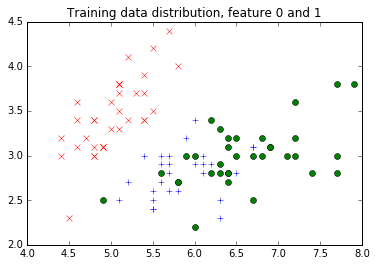

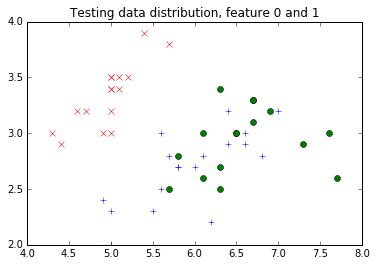

In [5]:
# Let's plot the first two features together with the label.
# Remember, while we are plotting the testing feature distribution
# here too, you might not be supposed to do so in real research,
# because one should not peek into the testing data.
legend = ['rx', 'b+', 'go']
pyplot.title("Training data distribution, feature 0 and 1")
for i in range(3):
    pyplot.plot(train_features[train_labels==i, 0], train_features[train_labels==i, 1], legend[i])
pyplot.figure()
pyplot.title("Testing data distribution, feature 0 and 1")
for i in range(3):
    pyplot.plot(test_features[test_labels==i, 0], test_features[test_labels==i, 1], legend[i])

Now, as promised, let's put things into a Caffe2 DB. In this DB, what would happen is that we will use "train_xxx" as the key, and use a TensorProtos object to store two tensors for each data point: one as the feature and one as the label. We will use Caffe2 python's DB interface to do so.

In [6]:
# First, let's see how one can construct a TensorProtos protocol buffer from numpy arrays.
feature_and_label = caffe2_pb2.TensorProtos()
feature_and_label.protos.extend([
    utils.NumpyArrayToCaffe2Tensor(features[0]),
    utils.NumpyArrayToCaffe2Tensor(labels[0])])
print('This is what the tensor proto looks like for a feature and its label:')
print(str(feature_and_label))
print('This is the compact string that gets written into the db:')
print(feature_and_label.SerializeToString())

This is what the tensor proto looks like for a feature and its label:
protos {
  dims: 4
  data_type: FLOAT
  float_data: 5.40000009537
  float_data: 3.0
  float_data: 4.5
  float_data: 1.5
}
protos {
  data_type: INT32
  int32_data: 1
}

This is the compact string that gets written into the db:

�̬@  @@  �@  �?
"


In [7]:
# Now, actually write the db.

def write_db(db_type, db_name, features, labels):
    db = core.C.create_db(db_type, db_name, core.C.Mode.write)
    transaction = db.new_transaction()
    for i in range(features.shape[0]):
        feature_and_label = caffe2_pb2.TensorProtos()
        feature_and_label.protos.extend([
            utils.NumpyArrayToCaffe2Tensor(features[i]),
            utils.NumpyArrayToCaffe2Tensor(labels[i])])
        transaction.put(
            'train_%03d'.format(i),
            feature_and_label.SerializeToString())
    # Close the transaction, and then close the db.
    del transaction
    del db

write_db("minidb", "iris_train.minidb", train_features, train_labels)
write_db("minidb", "iris_test.minidb", test_features, test_labels)

Now, let's create a very simple network that only consists of one single TensorProtosDBInput operator, to showcase how we load data from the DB that we created. For training, you might want to do something more complex: creating a network, train it, get the model, and run the prediction service. To this end you can look at the MNIST tutorial for details.

In [8]:
net_proto = core.Net("example_reader")
dbreader = net_proto.CreateDB([], "dbreader", db="iris_train.minidb", db_type="minidb")
net_proto.TensorProtosDBInput([dbreader], ["X", "Y"], batch_size=16)

print("The net looks like this:")
print(str(net_proto.Proto()))

The net looks like this:
name: "example_reader"
op {
  output: "dbreader"
  name: ""
  type: "CreateDB"
  arg {
    name: "db_type"
    s: "minidb"
  }
  arg {
    name: "db"
    s: "iris_train.minidb"
  }
}
op {
  input: "dbreader"
  output: "X"
  output: "Y"
  name: ""
  type: "TensorProtosDBInput"
  arg {
    name: "batch_size"
    i: 16
  }
}



In [9]:
workspace.CreateNet(net_proto)

True

In [10]:
# Let's run it to get batches of features.
workspace.RunNet(net_proto.Proto().name)
print("The first batch of feature is:")
print(workspace.FetchBlob("X"))
print("The first batch of label is:")
print(workspace.FetchBlob("Y"))

# Let's run again.
workspace.RunNet(net_proto.Proto().name)
print("The second batch of feature is:")
print(workspace.FetchBlob("X"))
print("The second batch of label is:")
print(workspace.FetchBlob("Y"))

The first batch of feature is:
[[ 5.19999981  4.0999999   1.5         0.1       ]
 [ 5.0999999   3.79999995  1.5         0.30000001]
 [ 6.9000001   3.0999999   4.9000001   1.5       ]
 [ 7.69999981  2.79999995  6.69999981  2.        ]
 [ 6.5999999   2.9000001   4.5999999   1.29999995]
 [ 6.30000019  2.79999995  5.0999999   1.5       ]
 [ 7.30000019  2.9000001   6.30000019  1.79999995]
 [ 5.5999999   2.9000001   3.5999999   1.29999995]
 [ 6.5         3.          5.19999981  2.        ]
 [ 5.          3.4000001   1.5         0.2       ]
 [ 6.9000001   3.0999999   5.4000001   2.0999999 ]
 [ 6.          3.4000001   4.5         1.60000002]
 [ 5.4000001   3.4000001   1.70000005  0.2       ]
 [ 6.30000019  2.70000005  4.9000001   1.79999995]
 [ 5.19999981  2.70000005  3.9000001   1.39999998]
 [ 6.19999981  2.9000001   4.30000019  1.29999995]]
The first batch of label is:
[0 0 1 2 1 2 2 1 2 0 2 1 0 2 1 1]
The second batch of feature is:
[[ 5.69999981  2.79999995  4.0999999   1.29999995]
 [ 5.0